## **Data Ingestion:**



In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Define BASE_FOLDER globally
BASE_FOLDER = "data"

def make_dir():
    """Creates required directories if they don't exist."""
    sub_dirs = ["raw", "raw/train", "raw/test"]  # Fixed missing comma
    for sub in sub_dirs:
        os.makedirs(os.path.join(BASE_FOLDER, sub), exist_ok=True)

def load_data(url):
    """Loads data from the provided URL."""
    return pd.read_csv(url)

def processing(df):
    """Filters, maps sentiment values, and shuffles data."""
    return (
        df[df["sentiment"].isin(["happiness", "sadness"])]
        .drop(columns=["tweet_id"], errors="ignore")  # Avoid KeyError if column is missing
        .assign(sentiment=lambda x: x["sentiment"].map({"happiness": 1, "sadness": 0}))
        .sample(frac=1, random_state=42)  # Shuffle the data
    )

def save_data(final_df):
    """Splits data into train and test sets and saves them."""
    train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)

    train_df.to_csv(os.path.join(BASE_FOLDER, "raw/train", "train.csv"), index=False)
    test_df.to_csv(os.path.join(BASE_FOLDER, "raw/test", "test.csv"), index=False)

def main():
    make_dir()
    url = "https://raw.githubusercontent.com/campusx-official/jupyter-masterclass/main/tweet_emotions.csv"

    df = load_data(url)
    final_df = processing(df)
    save_data(final_df)

if __name__ == "__main__":
    main()


## **Data cleaning:**

In [ ]:
import re
# NLTK for natural language processing
import nltk
from nltk.corpus import stopwords    # For stopwords
from nltk.tokenize import word_tokenize # For tokenization
from nltk.stem import PorterStemmer, WordNetLemmatizer # For stemming and lemmatization

# Downloading NLTK data
nltk.download('stopwords')   # Downloading stopwords data
nltk.download('punkt')       # Downloading tokenizer data
nltk.download('wordnet')     # Downloading WordNet data for lemmatization

In [ ]:


def data_cleaning(text_series):
    """Cleans the text data by removing URLs, emails, numbers, and punctuation."""
    number_pattern = r"(?<=\D)\d+|\d+(?=\D)"  # Removes numbers but keeps letters
    url_pattern = r"https?://\S+|www\.\S+"
    email_pattern = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b"
    punctuation_pattern = r"[^\w\s]"

    return (
        text_series.astype(str)  # Ensure text is string
        .str.lower()
        .str.replace(url_pattern, " ", regex=True)
        .str.replace(email_pattern, " ", regex=True)
        .str.replace(number_pattern, " ", regex=True)
        .str.replace(punctuation_pattern, " ", regex=True)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)  # Normalize spaces
    )

def remove_short_words(text_series, min_length=3):
    """Removes words shorter than `min_length` characters."""
    return text_series.apply(lambda x: " ".join([word for word in x.split() if len(word) >= min_length]))

def lemmatization(text_series):
    """Lemmatizes words using WordNetLemmatizer."""
    lemmatizer = WordNetLemmatizer()
    return text_series.apply(lambda x: " ".join([lemmatizer.lemmatize(word, pos="v") for word in x.split()]))

def remove_stopwords(text_series):
    """Removes stopwords from text."""
    stop_words = frozenset(stopwords.words("english"))  # Faster lookup
    return text_series.apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

def normalize(df):
    """Applies text preprocessing steps."""
    df["content"] = data_cleaning(df["content"])
    df["content"] = remove_short_words(df["content"])
    df["content"] = lemmatization(df["content"])
    df["content"] = remove_stopwords(df["content"])
    return df

def main():
    train_data = pd.read_csv("/content/data/raw/train/train.csv")
    test_data = pd.read_csv("/content/data/raw/test/test.csv")

    # Transform the data
    train_processed_data = normalize(train_data)
    test_processed_data = normalize(test_data)

    # Store the data inside data/processed
    data_path = os.path.join("./data", "interim")
    os.makedirs(data_path, exist_ok=True)

    train_processed_data.to_csv(os.path.join(data_path, "train_processed.csv"), index=False)
    test_processed_data.to_csv(os.path.join(data_path, "test_processed.csv"), index=False)


if __name__ == "__main__":
    main()


## **Feature Engineering:**

In [ ]:
import pickle
import pandas as pd
import os
import logging
import yaml
from sklearn.feature_extraction.text import CountVectorizer

# Set up logger
logger = logging.getLogger("feature_engineering")
logger.setLevel(logging.DEBUG)

# Remove existing handlers to avoid duplicates
if logger.hasHandlers():
    logger.handlers.clear()

# Define log file path
os.makedirs("logs", exist_ok=True)
log_file_path = "logs/feature_engineering.log"

# Delete the log file if it exists
if os.path.exists(log_file_path):
    os.remove(log_file_path)

# FileHandler to log messages to a file
file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.DEBUG)

# ConsoleHandler to log messages to the console
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)

# Create a formatter and attach it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Add handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

def load_params(params_path: str) -> dict:
    """Load parameters from a YAML file."""
    try:
        with open(params_path, "r") as file:
            params = yaml.safe_load(file)
            if params is None:
                raise ValueError(f"YAML file {params_path} is empty or invalid.")
        logger.debug("Parameters retrieved from %s", params_path)
        return params
    except FileNotFoundError:
        logger.error("File not found: %s", params_path)
        raise
    except yaml.YAMLError as e:
        logger.error("YAML error: %s", e)
        raise
    except Exception as e:
        logger.error("Unexpected error: %s", e)
        raise

def load_data(path: str) -> pd.DataFrame:
    """Load data from a CSV file."""
    try:
        df = pd.read_csv(path)
        df.fillna("", inplace=True)
        logger.debug("Data loaded successfully from %s", path)
        return df
    except FileNotFoundError:
        logger.error("File not found: %s", path)
        raise
    except Exception as e:
        logger.error("Error loading file %s: %s", path, e)
        raise

def bow(train: pd.DataFrame, test: pd.DataFrame, max_feature: int):
    """Perform Bag-of-Words transformation."""
    try:
        x_train = train["content"].values
        y_train = train["sentiment"].values
        x_test = test["content"].values
        y_test = test["sentiment"].values

        vectorizer = CountVectorizer(max_features=max_feature)
        x_train_bow = vectorizer.fit_transform(x_train)
        x_test_bow = vectorizer.transform(x_test)

        train_df = pd.DataFrame(x_train_bow.toarray())
        train_df["label"] = y_train
        test_df = pd.DataFrame(x_test_bow.toarray())
        test_df["label"] = y_test

        # Ensure the models directory exists
        os.makedirs("models", exist_ok=True)
        pickle.dump(vectorizer, open("models/vectorizer.pkl", "wb"))
        logger.debug("Vectorizer saved successfully to models/vectorizer.pkl")

        return train_df, test_df
    except Exception as e:
        logger.error("Error in Bag-of-Words transformation: %s", e)
        raise

def main():
    try:
        logger.info("Starting feature engineering process.")
        params = load_params("params.yaml")
        max_features = params["feature_engineering"]["max_features"]
    except Exception as e:
        logger.error("Error loading parameters: %s", e)
        return

    try:
        train = load_data(os.path.join("/content", "data", "interim", "train_processed.csv"))
        test = load_data(os.path.join("/content", "data", "interim", "test_processed.csv"))
    except Exception as e:
        logger.error("Error loading data: %s", e)
        return

    try:
        train_df, test_df = bow(train, test, max_features)
        logger.info("Bag-of-Words transformation completed successfully.")
        print("Training DataFrame:")
        print(train_df.head())  # Replace display with print for standalone scripts
        print("\nTesting DataFrame:")
        print(test_df.head())  # Replace display with print for standalone scripts
    except Exception as e:
        logger.error("Error in Bag-of-Words transformation: %s", e)
        return

if __name__ == "__main__":
    main()


In [ ]:
train= pd.read_csv("/content/data/interim/train_processed.csv")
test=pd.read_csv("/content/data/interim/test_processed.csv")
train.fillna('', inplace=True)
test.fillna('', inplace=True)

In [ ]:
x_train= train["content"].values
y_train= train["sentiment"].values
x_test= test["content"].values
y_test= test["sentiment"].values

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorize=CountVectorizer(max_features=500)
x_train_bow = vectorize.fit_transform(x_train,)
x_test_bow = vectorize.transform(x_test)

In [ ]:
train_df = pd.DataFrame(x_train_bow.toarray())
train_df['label'] = y_train
test_df = pd.DataFrame(x_test_bow.toarray())
test_df['label'] = y_test

## **Model Building:**



Accuracy: 0.6216
Precision: 0.7054
Recall: 0.6216
F1 Score: 0.5845


## Classification Report

              precision    recall  f1-score   support

           0       0.57      0.93      0.71      1517
           1       0.84      0.33      0.47      1596

    accuracy                           0.62      3113
   macro avg       0.70      0.63      0.59      3113
weighted avg       0.71      0.62      0.58      3113



## Confusion Matrix

/Users/santoshkumar/Data_science/dvc-pipeline-tweet/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/santoshkumar/Data_science/dvc-pipeline-tweet/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python 

MLflow Run Completed Successfully!


/Users/santoshkumar/Data_science/dvc-pipeline-tweet/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


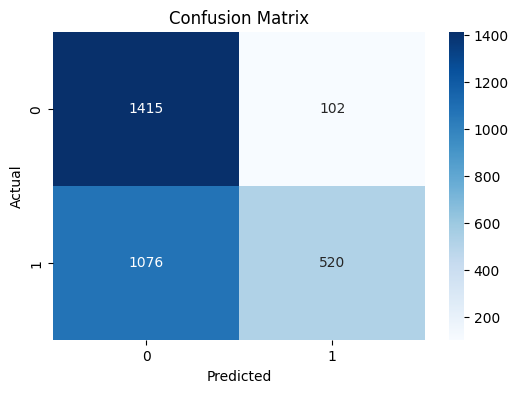

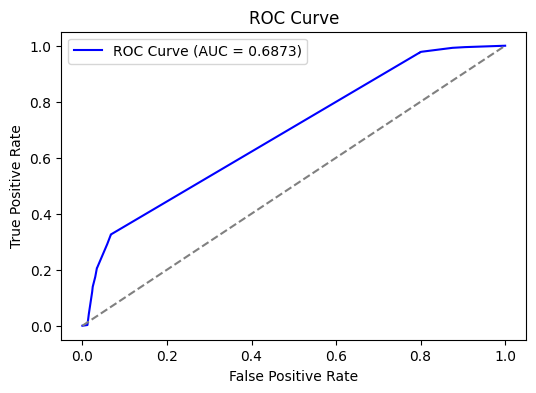

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import os
from datetime import datetime
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    f1_score, precision_score, recall_score, roc_curve, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from IPython.display import display, Markdown

# Load Data
train_path = "/Users/santoshkumar/Data_science/dvc-pipeline-tweet/data/processed/train_bow.csv"
test_path = "/Users/santoshkumar/Data_science/dvc-pipeline-tweet/data/processed/test_bow.csv"
notebook_path = "/Users/santoshkumar/Data_science/dvc-pipeline-tweet/notebooks/exp1.ipynb"


train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Split Features and Labels
X_train = train_df.drop(columns=["label"])
y_train = train_df["label"]
X_test = test_df.drop(columns=["label"])
y_test = test_df["label"]

# Set MLflow Experiment
experiment_name = "tweet_emotion_classification"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# Start MLflow Run
with mlflow.start_run(run_name=f"DecisionTree_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"):
    # Define Model with Hyperparameters
    dt = DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state=42)

    # Measure training time
    start_time = time.time()
    dt.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_pred = dt.predict(X_test)
    
    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

    # Print Metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    display(Markdown("## Classification Report"))
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Visualization
    display(Markdown("## Confusion Matrix"))
    class_labels = np.unique(y_test)  # Dynamically getting labels
    plt.figure(figsize=(6,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")


    # Compute probabilities and ROC metrics
    y_proba = dt.predict_proba(X_test)[:, 1]  # Get positive class probabilities
    fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)  # Compute ROC curve
    roc_auc = roc_auc_score(y_test, y_proba)  # Compute ROC AUC score

    # Plot ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig("roc_curve.png")

    # Log ROC Curve
    mlflow.log_artifact("roc_curve.png")
    mlflow.log_metric("auc", roc_auc)


    # MLflow Logging
    mlflow.log_params(dt.get_params())  # Log all model hyperparameters
    
    mlflow.log_metrics({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "training_time": train_time
    })

    # Log metadata
    mlflow.set_tag("experiment_version", "1.0")
    mlflow.set_tag("author", "Santosh")
    mlflow.set_tag("description", "Decision Tree model for tweet sentiment classification")

    # Log Notebook
    mlflow.log_artifact(notebook_path)

    # Log Model with Signature and Input Example
    input_example = X_test.iloc[:1]  # Sample input
    signature = infer_signature(X_train, dt.predict(X_train))
    mlflow.sklearn.log_model(dt, "decision_tree_model", signature=signature, input_example=input_example)

    # Log Input Data
    mlflow.log_input(mlflow.data.from_pandas(train_df), context="training")
    mlflow.log_input(mlflow.data.from_pandas(test_df), context="validation")

print("MLflow Run Completed Successfully!")